## Some setup and os tools

In [21]:
import numpy
import pandas
import os
import matplotlib.pyplot as plot
import seaborn as sns
from shutil import copyfile
from IPython.display import IFrame, display, HTML
%matplotlib inline

# This is supposed to enhance default pandas display
pandas.set_option('display.width',200)
pandas.set_option('display.max_colwidth',200)

# the folder where this experiment will be stored
EXPERIMENT = 'multinomial_naivebayes_unbalanced'

# The name of the docker image (used to display docker command to copy apply files to windows host)
DOCKER_IMAGE_NAME = 'dev_ds_1'

# Some common resources
PANDAS_STORE = '../PandasStore'
PICKLE_EXTENSION = '.pkl'
CLEAN_TRAINING_DATA = 'clean_training'
CLEAN_CHALLENGE_DATA = 'clean_challenge'

# Other useful constants
ZIP_EXTENSION = '.zip'
SEP_IN_FILE_NAME = '$'

# Try to have a minimal decoration in notebook output
def print_html(s):
    display(HTML(s, metadata=dict(isolated=True)))

def start_small():
    display(HTML('<span><small>', metadata=dict(isolated=True)))

def print_small(s):
    print_html('<small>',s,'</small>')

def end_small():
    display(HTML('</small></span>', metadata=dict(isolated=True)))

def start_italic():
    display(HTML('<i>', metadata=dict(isolated=True)))

def print_italic(s):
    print_html('<i>'+s+'</i>')

def end_italic():
    display(HTML('</i>', metadata=dict(isolated=True)))

def start_bold():
    display(HTML('<b>', metadata=dict(isolated=True)))

def print_bold(s):
    print_html('<b>'+s+'</b>')

def end_bold():
    display(HTML('</b>', metadata=dict(isolated=True)))

def print_bullet(s):
    print_html('<li>'+s)

def print_section(s):
    print_bold(s)
    print_html('<HR>')

def print_done(s):
    print_html('<span style="color:LIMEGREEN"><small><b><i>'+s+'</i></b><p></p></small></span>')

def print_info(s):
    print_html('<span style="color:LIMEGREEN"><small>'+s+'</small></span>')

def print_warning(s):
    print_html('<span style="color:LIGHTSALMON"><small>'+s+'</small></span>')

## Plenty of small tools to help not creating a huge mess

def global_pandas_store_file_name(file_name,ext='.pkl'):
    return PANDAS_STORE +'/'+file_name+ext

def local_pandas_store_file_name(file_name):
    return env_file_name(file_name,PICKLE_EXTENSION)

def env_path():
    return '../'+EXPERIMENT

def env_file_name(file_name,ext=''):
    return env_path()+'/'+file_name+ext

def copy_from_pandas_store_if_missing(file_name):
    if not os.path.exists(env_file_name(file_name)):
        print_info('Make local copy of %s' % global_pandas_store_file_name(file_name))
        copyfile(global_pandas_store_file_name(file_name),local_pandas_store_file_name(file_name))

def prepare_environnement():
    print_section('Prepare %s environment' % EXPERIMENT)
    if not os.path.exists(env_path()):
        os.mkdir(env_path())
    copy_from_pandas_store_if_missing(CLEAN_TRAINING_DATA)
    copy_from_pandas_store_if_missing(CLEAN_CHALLENGE_DATA)
    print_done('Done')
    print

## Tools to cache important and costly data

def load_dataframe(file_name):
    df = pandas.read_pickle(local_pandas_store_file_name(file_name))
    return df

def save_dataframe(df,file_name):
    print_info('Save %s' % file_name )
    df.to_pickle(local_pandas_store_file_name(file_name))

def load_or_build_dataframe(dataframe_name,file_name,builder,dataframe):
    print_section('%s: Load or rebuild %s' % (dataframe_name,file_name))
    if os.path.exists(local_pandas_store_file_name(file_name)):
        print_info("!!!!! %s is cached!!!" % local_pandas_store_file_name(file_name))
        df = load_dataframe(file_name)
    else:
        print_warning("!!!!! %s does not exists!!!" % local_pandas_store_file_name(file_name))
        print_warning('Rebuild and save it')
        df = builder(dataframe)
        save_dataframe(df,file_name)
    print_done('Done:%s contains %d lines' % (file_name,len(df)))
    return df

# Code to generate all combination of numeric features
from itertools import compress, product
from itertools import chain, combinations

def all_numeric_columns(dataframe):
    l = list()
    for name in dataframe.columns:
        if dataframe.dtypes[name] in ['int64','float64'] and name not in ['test_id','id','qid1','qid2','is_duplicate']:
            l.append( name)
    return l

def all_subsets(ss):
    return list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1))))

def clean_combination_name(c):
    return str(numpy.asarray(c)).replace("' '","+").replace("['","").replace("']","").replace("'","").replace(" ","").replace('\n','+')

def clean_all_combination_names(dataframe):
    for c in all_subsets(all_numeric_columns(dataframe)):
        if len(c)>0:
            print('|%s|'% clean_combination_name(c))

#print( 'All numeric columns\n%s' % all_numeric_columns(train_dataframe))
#print('All combinations of numeric columns\n %d combinations\n' % len(all_subsets(all_numeric_columns(train_dataframe))))
#for c in all_subsets(all_numeric_columns(train_dataframe)):
#    print(c)
#clean_all_combination_names(train_dataframe)
#print( '%d combination of features will be studied' % (len(list(all_subsets(all_numeric_columns(train_dataframe))))-1))

# code to put plots in a grid

def multiplot_from_generator(g, num_columns, figsize_for_one_row=None):
    # call 'next(g)' to get past the first 'yield'
    next(g)
    # default to 15-inch rows, with square subplots
    if figsize_for_one_row is None:
        figsize_for_one_row = (15, 15/num_columns)
    try:
        while True:
            # call plt.figure once per row
            plot.figure(figsize=figsize_for_one_row)
            for col in range(num_columns):
                ax = plot.subplot(1, num_columns, col+1)
                next(g)
    except StopIteration:
        pass

# apply tools
def apply_file_name(criteria,kind,model_key,ext='.csv'):
    return env_file_name(SEP_IN_FILE_NAME.join((EXPERIMENT,criteria,kind,clean_combination_name(model_key).replace('/','_div_')))+ext)

def apply_absolute_file_name(criteria,kind,model_key,ext='.csv'):
    return str(os.path.abspath(apply_file_name(criteria,kind,model_key,ext=ext)))

# Zip tools
from zipfile import ZipFile,ZIP_DEFLATED 
import zlib
import os
from pathlib import Path

def zip_file_name(original_file_name):
    return str(Path(original_file_name).with_suffix('.zip'))

def zip_file_and_delete(original_file_name):
    zip_name = zip_file_name(original_file_name) 
    zip = ZipFile(str(zip_name), 'w',compression=ZIP_DEFLATED)
    zip.write(original_file_name)
    zip.close()
    os.unlink(original_file_name)
    return zip_name

# Excel tools
def excel_file_name(file_name):
    return env_file_name(file_name+'.xlsx')

def pandas_to_excel(dataframe,file_name):
    dataframe.to_excel(excel_file_name(SEP_IN_FILE_NAME.join([EXPERIMENT,file_name])),float_format="%.4f")

## Build simple features

In [2]:

def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].apply(function)
    return dataframe[output_column_name]


def build_all_simple_features(dataframe):
    start_small()
    print_warning('Compute common_words between question1 & question2')
    add_column_from_column(dataframe,'nb_words_question1','question1',lambda x: len(x.split()))
    add_column_from_column(dataframe,'nb_words_question2','question2',lambda x: len(x.split()))
    print_warning('Compute Nb common_words between question1 & question2')
    add_column_from_columns(dataframe,'common_words',lambda r: list(set(r.question1.split())&set(r.question2.split())))
    add_column_from_column(dataframe,'nb_common_words','common_words',len)
    print_warning('Compute Nb words in question1,question2 not in common words')
    add_column_from_columns(dataframe,'nb_words_question1-common_words',lambda r: len(list(set(r.question1.split())-set(r.common_words))))
    add_column_from_columns(dataframe,'nb_words_question2-common_words',lambda r: len(list(set(r.question2.split())-set(r.common_words))))
    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_columns(dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)',lambda r: r.nb_common_words/(r.nb_words_question1+r.nb_words_question2))
    end_small()
    dataframe=dataframe.drop(columns='common_words')
    return dataframe

# First steps
* Train & Challenge: Read original data (minimal low level cleaning already done)
* Train & Challenge: Compute basic features
    * Nb common words between question1 & question2
    * Nb words in question1 not in common words
    * Nb words in question2 not in common words
    * Nb common words/(nb words in question1 + nb words in question2)


In [22]:
prepare_environnement()
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)

train_dataframe=load_or_build_dataframe('Training basic features','training_basic_features',build_all_simple_features,train_dataframe)
challenge_dataframe=load_or_build_dataframe('Challenge basic features','challenge_basic_features',build_all_simple_features,challenge_dataframe)

In [4]:
train_dataframe.head()

,id,qid1,qid2,question1,question2,is_duplicate,nb_words_question1,nb_words_question2,nb_common_words,nb_words_question1-common_words,nb_words_question2-common_words,nb_common_words/(nb_words_question1+nb_words_question2)
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,14,12,10,2,1,0.384615
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,8,13,4,4,8,0.190476
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,14,10,3,11,7,0.125000
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,11,9,0,10,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,13,7,2,11,5,0.100000


In [5]:
challenge_dataframe.head()

,test_id,question1,question2,nb_words_question1,nb_words_question2,nb_common_words,nb_words_question1-common_words,nb_words_question2-common_words,nb_common_words/(nb_words_question1+nb_words_question2)
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?,11,14,2,9,11,0.080000
1,1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?,14,7,4,10,3,0.190476
2,2,What but is the best way to send money from China to the US?,What you send money to China?,14,6,4,8,2,0.200000
3,3,Which food not emulsifiers?,What foods fibre?,4,3,0,4,3,0.000000
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,4,6,3,1,3,0.300000


Define some code to easily compute AUC of these basic features

In [6]:

from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(dataframe['is_duplicate'],dataframe[column_name])

def show_AUC(dataframe,column_name):
    print_bullet('AUC %s-is_duplicate: %f' % (column_name,simple_AUC(dataframe,column_name)))

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    # Let multiplot_generator figure the size
    #plot.figure(figsize=(10, 7))
    plot.hist(dataframe[column_name][dataframe['is_duplicate']==1],bins=50,color=palette[3],label='Same',histtype='step')
    plot.hist(train_dataframe[column_name][dataframe['is_duplicate']==0],bins=50,color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC is_duplicate/%s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()


def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)
        yield
        display_simple_AUC(dataframe,name)
    print_done('Done')


def show_all_simple_AUC_in_grid(dataframe,nb_columns=2):
    multiplot_from_generator(show_all_simple_AUC(dataframe), nb_columns)

## Is there a bit of information in our features ??

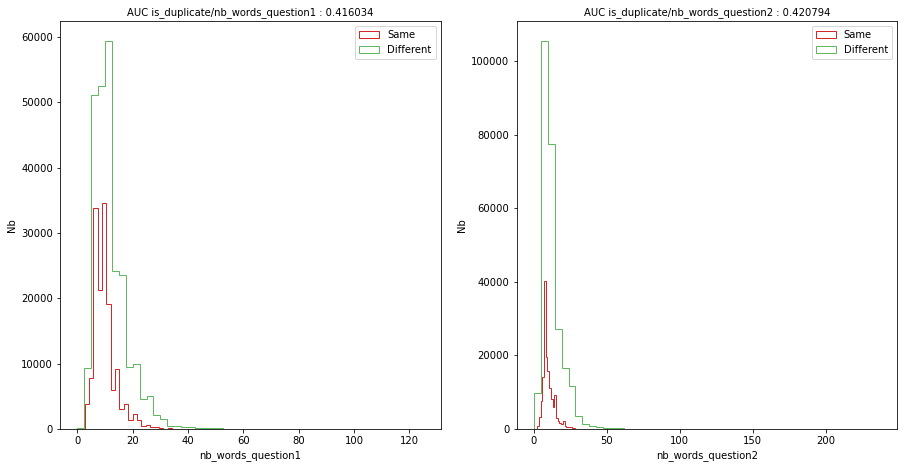

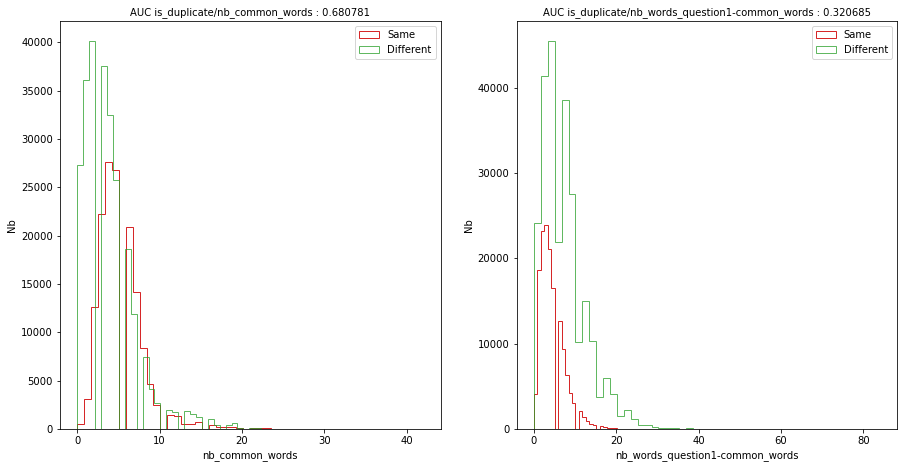

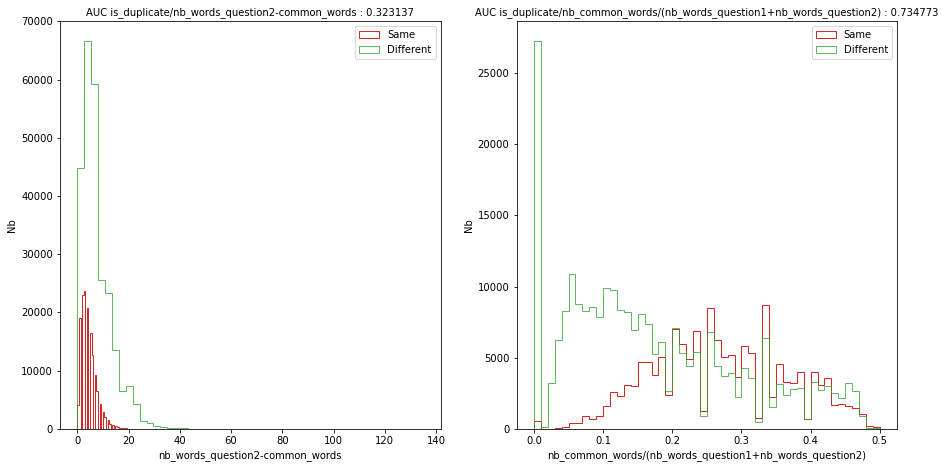

In [7]:
show_all_simple_AUC_in_grid(train_dataframe,nb_columns=2)

## Code to build simple naive bayes model on these features

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

def build_naivebayes_model_with_test(input,column_names,target,show=True):
    # print_bullet('Multinomial Naive Bayes with test on %s' % clean_combination_name(column_names))
    input_train = pandas.DataFrame()
    for column_name in column_names:
        input_train[column_name]=input[column_name]
    target_train = target
    input_train,input_test,target_train,target_test = train_test_split(input_train,target_train,random_state=42,test_size=0.2)
    if show:
        print_info( 'Validation %d Test %d' % (len(input_train),len(input_test)))
    model = MultinomialNB()
    #naive_bayes_classifier_with_test=ComplementNB()
    model.fit(input_train,target_train)
    prediction=model.predict(input_test)
    prediction_proba=model.predict_proba(input_test)
    res = metrics.classification_report(target_test,prediction,output_dict=True)
    accuracy = res['accuracy']
    score = res['0']['f1-score']*(1-0.17)+res['1']['f1-score']*.17
    logloss_classif = metrics.log_loss(target_test,prediction)
    logloss_proba = metrics.log_loss(target_test,prediction_proba)
    if show:
        print(metrics.classification_report(target_test,prediction))
        print_info( 'Test logloss %.4f accuracy %.4f score %.4f %s' % (logloss_proba,accuracy,score,clean_combination_name(column_names)))
    #print(metrics.accuracy_score(target_test,prediction))
    #print(metrics.confusion_matrix(target_test,prediction))
    return model,accuracy,score,logloss_classif,logloss_proba

def build_naivebayes_model_full(input,column_names,target,show=True):
    #print_bullet('Multinomial Naive Bayes full on %s' % clean_combination_name(column_names))
    input_train = pandas.DataFrame()
    for column_name in column_names:
        input_train[column_name]=input[column_name]
    target_train = target
    model=MultinomialNB()
    model.fit(input_train,target_train)
    prediction=model.predict(input_train)
    prediction_proba=model.predict_proba(input_train)
    res = metrics.classification_report(target,prediction,output_dict=True)
    accuracy = res['accuracy']
    score = res['0']['f1-score']*(1-0.17)+res['1']['f1-score']*.17
    logloss_classif = metrics.log_loss(target,prediction)
    logloss_proba = metrics.log_loss(target,prediction_proba)
    if show:
        print_info( 'Full logloss %.4f accuracy %.4f score %.4f %s' % (logloss_proba,accuracy,score,clean_combination_name(column_names)))
        print(metrics.classification_report(target,prediction))
    return model,accuracy,score,logloss_classif,logloss_proba

# just in case model_results has been lost in action
def build_model_results(models_dict):
    results = pandas.DataFrame(models_dict).transpose()
    results = results.drop(columns=['model_test','model_full','column_names'])
    results['accuracy_test'] = results['accuracy_test'].astype('float64')
    results['score_test'] = results['score_test'].astype('float64')
    results['accuracy_full'] = results['accuracy_full'].astype('float64')
    results['score_full'] = results['score_full'].astype('float64')
    results['logloss_classif_test'] = results['logloss_classif_test'].astype('float64')
    results['logloss_proba_test'] = results['logloss_proba_test'].astype('float64')
    results['logloss_classif_full'] = results['logloss_classif_full'].astype('float64')
    results['logloss_proba_full'] = results['logloss_proba_full'].astype('float64')
    return results

# bad design choice : a DataFrame can be more convenient than a dict
# But then, it is convenient to suppress all non numeric/string columns
def models_dict_to_models_results(models_dict):
    results = pandas.DataFrame(models_dict).transpose()
    results = results.drop(columns=['model_test','model_full','column_names'])
    results['accuracy_test'] = results['accuracy_test'].astype('float64')
    results['score_test'] = results['score_test'].astype('float64')
    results['accuracy_full'] = results['accuracy_full'].astype('float64')
    results['score_full'] = results['score_full'].astype('float64')
    results['logloss_classif_test'] = results['logloss_classif_test'].astype('float64')
    results['logloss_proba_test'] = results['logloss_proba_test'].astype('float64')
    results['logloss_classif_full'] = results['logloss_classif_full'].astype('float64')
    results['logloss_proba_full'] = results['logloss_proba_full'].astype('float64')
    return results

from tqdm.notebook import tqdm

def build_model(train_dataframe,column_names,target,show=True):
    m_t,a_t,s_t,l_c_t,l_p_t = build_naivebayes_model_with_test(train_dataframe,column_names,target,show=show)
    m_f,a_f,s_f,l_c_f,l_p_f = build_naivebayes_model_full(train_dataframe,column_names,target,show=show)
    print_info( '%.4f %.4f|%.4f %.4f|%.4f %.4f|%s' % (l_p_t,l_p_f,a_t,a_f,s_t,s_f,clean_combination_name(column_names)))
    return {'column_names':column_names,'model_test':m_t,'accuracy_test':a_t,'score_test':s_t,'logloss_classif_test':l_c_t,'logloss_proba_test':l_p_t,'model_full':m_f,'accuracy_full':a_f,'score_full':s_f,'logloss_classif_full':l_c_f,'logloss_proba_full':l_p_f}

def build_model_on_all_subset_of_simple_features(dataframe,target):
    print_section('%s : Build all models (with test+full) on every combination of simple features' % EXPERIMENT)
    models_dict = dict()
    print_info('logloss&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;accuracy&nbsp;&nbsp&nbsp;&nbsp;&nbsp;&nbsp;score&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;features')
    print_info('test&nbsp;&nbsp;&nbsp;full&nbsp;&nbsp;|test&nbsp;&nbsp;&nbsp;full&nbsp;&nbsp;|test&nbsp;&nbsp;&nbsp;full&nbsp;&nbsp;|')
    for c in tqdm(all_subsets(all_numeric_columns(dataframe))):
        if (len(c)) >0:
            models_dict[clean_combination_name(c)] = build_model(dataframe,c,target,show=False)
    print_done('Done')
    # Design mistake : need to convert dict to dataframe :(
    return models_dict,models_dict_to_models_results(models_dict)


In [9]:

# build one model 
model = build_model(train_dataframe,['nb_words_question1'],train_dataframe['is_duplicate'])
# build ALL models
# 2 very important global variables: all_models_dict & model_results
all_models_dict,model_results = build_model_on_all_subset_of_simple_features(train_dataframe,train_dataframe['is_duplicate'])


precision    recall  f1-score   support

           0       0.63      1.00      0.77     50803
           1       0.00      0.00      0.00     30055

    accuracy                           0.63     80858
   macro avg       0.31      0.50      0.39     80858
weighted avg       0.39      0.63      0.48     80858



precision    recall  f1-score   support

           0       0.63      1.00      0.77    255027
           1       0.00      0.00      0.00    149263

    accuracy                           0.63    404290
   macro avg       0.32      0.50      0.39    404290
weighted avg       0.40      0.63      0.49    404290



Some code for an easy apply (display kaggle command for subscription)

In [10]:
# Suppose global variable all_models_dict is available !

# kind is 'test or 'full'
def retrieve_model(model_key,kind):
    combination_results = all_models_dict[model_key]
    column_names = combination_results['column_names']
    model = combination_results['model_'+kind]
    return model,numpy.asarray(column_names)
    
# return a dataframe fully ready to be converted in csv and published into kaggle
def simple_apply(model_key,input_dataframe,kind,proba=True):
    model,column_names=retrieve_model(model_key,kind)
    input_for_prediction=input_dataframe[column_names]
    res = pandas.DataFrame()
    if 'test_id' in input_dataframe.columns:
        res['test_id']=input_dataframe['test_id']
    if proba:
        res['is_duplicate']=pandas.Series(model.predict_proba(input_for_prediction)[:,1],name='is_duplicate')
    else:
        res['is_duplicate']=pandas.Series(model.predict(input_for_prediction),name='is_duplicate')
    return res


def show_docker_cp_command(absolute_file_name):
    return 'docker cp '+ DOCKER_IMAGE_NAME+':'+zip_file_name(absolute_file_name)+ ' c:\\temp\\outputs'

def show_kaggle_command(absolute_file_name):
    return 'kaggle competitions submit quora-question-pairs -f "' + zip_file_name(absolute_file_name) +'" -m "' + absolute_file_name +'"'

def show_docker_cp_commands(best_results):
    print_section('Use these commands to transfer apply results to windows host')
    for c in best_results['file_name'].apply(show_docker_cp_command):
        print_warning(c)
    print_done("")

def show_kaggle_commands(best_results):
    print_section('Use these commands to submit apply results to kaggle')
    for c in best_results['file_name'].apply(show_kaggle_command):
        print_warning(c)
    print_done("")
   

def submit_model(criteria,kind,input_dataframe,model_key,proba=True,show_how_to_publish=True,kaggle=False):
    absolute_file_name_csv = apply_absolute_file_name(criteria,kind,model_key)
    print_info('Doing apply')
    prediction = simple_apply(model_key,input_dataframe,kind,proba)
    print_info('Generating CSV file')
    prediction.to_csv(absolute_file_name_csv,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(absolute_file_name_csv)
    print_info('%s is ready' % absolute_file_name_csv)
    if show_how_to_publish:
        if kaggle:
            print_warning('Use this commands to submit apply results to kaggle')
            print_warning(show_kaggle_command(absolute_file_name_zip))
        else:
            print_warning('Use this command to transfer apply _results to Windows host')
            print_warning(show_docker_cp_command(absolute_file_name_csv))

# suppose global variable model_results is available
def find_best_models(top,criteria,kind):
    if 'logloss' in criteria:
        return model_results.nsmallest(top,criteria+'_'+kind)
    else:
        return model_results.nlargest(top,criteria+'_'+kind)

def submit_best_models(top,criteria,kind,input_dataframe,proba=True,kaggle=False):
    print_section('Submit best %d %s models by %s' % (top,kind,criteria))
    best_models = find_best_models(top,criteria,kind)
    best_models['model_key']=numpy.asarray(best_models.index)
    #best_models['file_name']=numpy.array([apply_file_name(criteria,kind,n) for n in best_models.index])
    best_models['file_name']=best_models['model_key'].apply(lambda mk: apply_absolute_file_name(criteria,kind,mk))
    best_models['model_key'].apply(lambda mk: submit_model(criteria,kind,input_dataframe,mk,proba=proba,show_how_to_publish=False,kaggle=kaggle))
    best_models['docker']=best_models['file_name'].apply(show_docker_cp_command)
    best_models['kaggle']=best_models['file_name'].apply(show_kaggle_command)
    print_done('Done')
    if kaggle:
        show_kaggle_commands(best_models)
    else:
        show_docker_cp_commands(best_models)
    return best_models



In [11]:
retrieve_model('nb_common_words+nb_common_words/(nb_words_question1+nb_words_question2)','full')
simple_apply('nb_common_words+nb_common_words/(nb_words_question1+nb_words_question2)',challenge_dataframe,'full')
find_best_models(2,'logloss_proba','full')
#submit_best_models('accuracy','full',train_dataframe)
#submit_best_models('score','full',challenge_dataframe)
# best_accuracy_full_models = submit_best_models(3,'accuracy','full',challenge_dataframe)
# show_docker_cp_commands(best_accuracy_full_models)


,accuracy_test,score_test,logloss_classif_test,logloss_proba_test,accuracy_full,score_full,logloss_classif_full,logloss_proba_full
nb_words_question2+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.646392,0.690074,12.213254,0.599169,0.647656,0.691144,12.169600,0.597289
nb_words_question1+nb_words_question1-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.645762,0.689335,12.235036,0.599585,0.646956,0.690319,12.193774,0.598615


## Find the best models for all metrics

In [12]:
print('%d models have been trained' %len(all_models_dict))
print('\nmax metrix\n',model_results.idxmax())
print('\nmin metrix\n',model_results.idxmin())

63 models have been trained

max metrix
 accuracy_test                                                 nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)
score_test                                                                                                            nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words
logloss_classif_test                                                                                                                               nb_words_question2+nb_words_question1-common_words
logloss_proba_test      nb_words_question1+nb_words_question2+nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)
accuracy_full                                                                                      nb_words_question2+nb_common_words+nb_words_question1-common_words+n

## Apply full models with best logloss 


In [13]:
#best_accuracy_full_models = submit_best_models(3,'accuracy','full',challenge_dataframe)
#show_docker_cp_commands(best_accuracy_full_models)
#best_score_full_models = submit_best_models(3,'score','full',challenge_dataframe)
#show_docker_cp_commands(best_score_full_models)
#best_accuracy_test_models = submit_best_models(3,'accuracy','test',challenge_dataframe)
#show_docker_cp_commands(best_accuracy_test_models)
#best_score_test_models = submit_best_models(3,'score','test',challenge_dataframe)
#show_docker_cp_commands(best_score_test_models)
best_logloss_proba_test = submit_best_models(3,'logloss_proba','test',challenge_dataframe,kaggle=True)
best_logloss_proba_full = submit_best_models(3,'logloss_proba','full',challenge_dataframe,kaggle=True)



In [14]:
show_docker_cp_commands(best_logloss_proba_full)
show_kaggle_commands(best_logloss_proba_full)

## Manual submission

In [15]:
submit_model('score','full',challenge_dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)',kaggle=true)

In [16]:

def submit_all_bests(criterias,input_dataframe,kaggle=False):
    kinds = ['full','test']
    print_section('Submit best models by %sx%s' % (criterias,kinds))
    all_file_names = list()
    for c in tqdm(criterias):
        for k in kinds:
            print_info('Best %s_%s' %(c,k))
            best_model = find_best_models(1,c,k)
            generated_file = apply_absolute_file_name(c,k,best_model.index)
            best_model['model_key']=numpy.asarray(best_model.index)
            best_model['model_key'].apply(lambda mk: submit_model(c,k,input_dataframe,mk,proba=True,show_how_to_publish=False,kaggle=kaggle))
            all_file_names.append(generated_file)
    print_done('Done')
    commands = pandas.DataFrame()
    commands['file_name']=all_file_names
    if kaggle:
        commands['kaggle'] = commands['file_name'].apply(show_kaggle_command)
        show_kaggle_commands(commands)
    else:
        commands['docker'] = commands['file_name'].apply(show_docker_cp_command)
        show_docker_cp_commands(commands)
    return commands


  

submit_all_bests(['accuracy','score','logloss_classif','logloss_proba'],challenge_dataframe,kaggle=True)


,file_name,kaggle
0,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$accuracy$full$nb_words_question2+nb_common_words+nb_words_question1-common_words+nb_words_question2-commo...,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$accuracy$full$nb_words_question2+nb_common_words+nb_w..."
1,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$accuracy$test$nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_w...,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$accuracy$test$nb_common_words+nb_words_question1-comm..."
2,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$score$full$nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words.csv,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$score$full$nb_common_words+nb_words_question1-common_..."
3,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$score$test$nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words.csv,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$score$test$nb_common_words+nb_words_question1-common_..."
4,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$logloss_classif$full$nb_words_question2+nb_common_words+nb_words_question1-common_words+nb_words_question...,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$logloss_classif$full$nb_words_question2+nb_common_wor..."
5,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$logloss_classif$test$nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_c...,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$logloss_classif$test$nb_common_words+nb_words_questio..."
6,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$logloss_proba$full$nb_words_question2+nb_words_question2-common_words+nb_common_words_div_(nb_words_quest...,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$logloss_proba$full$nb_words_question2+nb_words_questi..."
7,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$logloss_proba$test$nb_words_question2+nb_words_question2-common_words+nb_common_words_div_(nb_words_quest...,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced$logloss_proba$test$nb_words_question2+nb_words_questi..."


In [17]:
model_results

,accuracy_test,score_test,logloss_classif_test,logloss_proba_test,accuracy_full,score_full,logloss_classif_full,logloss_proba_full
nb_words_question1,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_words_question2,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_common_words,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_words_question1-common_words,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_words_question2-common_words,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
...,...,...,...,...,...,...,...,...
nb_words_question1+nb_words_question2+nb_common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.665339,0.701264,11.558913,0.800547,0.666888,0.702817,11.505434,0.796767
nb_words_question1+nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.661827,0.703018,11.680192,0.630167,0.662210,0.703442,11.666951,0.628233
nb_words_question1+nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.673143,0.707642,11.289379,0.900531,0.673237,0.707955,11.286133,0.898209
nb_words_question2+nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.673588,0.708096,11.274001,0.891399,0.673507,0.708318,11.276821,0.889994


In [20]:
def save_models_dict_to_excel(models_dict,file_name):
    results = models_dict_to_models_results(models_dict)
    results.to_excel(excel_file_name(SEP_IN_FILE_NAME.join([EXPERIMENT,file_name])),float_format="%.4f")

save_models_dict_to_excel(all_models_dict,'all_models')

